In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

#### Thiết lập font tiếng Việt cho matplotlib

In [2]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

#### LOAD VÀ CHUẨN BỊ DỮ LIỆU

In [3]:
def load_data(file_path):
    """Load dữ liệu từ file JSON"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def parse_data(data):
    texts = []
    all_labels = []
    entity_counts = defaultdict(int)
    sentiment_counts = defaultdict(int)
    aspect_sentiment_counts = defaultdict(lambda: defaultdict(int))
    
    for item in data:
        text = item['text']
        labels = item['labels']
        
        texts.append(text)
        all_labels.append(labels)
        
        for label in labels:
            start, end, entity, category = label
            aspect, sentiment = category.split('#')
            
            entity_counts[entity] += 1
            sentiment_counts[sentiment] += 1
            aspect_sentiment_counts[aspect][sentiment] += 1
    
    return texts, all_labels, entity_counts, sentiment_counts, aspect_sentiment_counts



# Example analysis
data = load_data('C:/Users/DELL/Tiki_ABSA/src/models/DistilBert_MultiTasking/data/labeled_data_normalized.json')

texts, all_labels, entity_counts, sentiment_counts, aspect_sentiment_counts = parse_data(data)

print(f"Số lượng đánh giá: {len(texts)}")
print(f"Tổng số entities được gán nhãn: {sum(entity_counts.values())}")
print(f"Số aspect categories: {len(aspect_sentiment_counts)}")
print(f"Số sentiment types: {len(sentiment_counts)}")

# Text statistics
text_lengths = [len(text) for text in texts]
word_counts = [len(text.split()) for text in texts]

print(f"\nThống kê độ dài text:")
print(f"  - Độ dài trung bình (ký tự): {np.mean(text_lengths):.1f}")
print(f"  - Độ dài trung bình (từ): {np.mean(word_counts):.1f}")
print(f"  - Min/Max độ dài: {min(text_lengths)}/{max(text_lengths)} ký tự")


Số lượng đánh giá: 4039
Tổng số entities được gán nhãn: 12279
Số aspect categories: 4
Số sentiment types: 3

Thống kê độ dài text:
  - Độ dài trung bình (ký tự): 119.5
  - Độ dài trung bình (từ): 26.8
  - Min/Max độ dài: 16/2225 ký tự


In [58]:
labels_data = []

for review_id, item in enumerate(data):
    for label in item.get('labels', []):
        if len(label) < 4:
            print(f"[Cảnh báo] Label không đủ phần tử tại review {review_id}: {label}")
            continue

        start_pos, end_pos, text_snippet, aspect_sentiment = label
        aspect = ''
        sentiment = None  # Mặc định là None nếu không có phần sau '#'

        if isinstance(aspect_sentiment, str):
            parts = aspect_sentiment.split('#')
            if len(parts) >= 1:
                aspect = parts[0].strip()
            if len(parts) == 2:
                sentiment = parts[1].strip()

        entity_length = len(text_snippet.strip())  # hoặc dùng len(text_snippet.split()) nếu muốn đếm số từ

        labels_data.append({
            'review_id': review_id,
            'start_pos': start_pos,
            'end_pos': end_pos,
            'text_snippet': text_snippet,
            'aspect_sentiment': aspect_sentiment,
            'aspect': aspect,
            'sentiment': sentiment,
            'entity_length': entity_length
        })

labels_df = pd.DataFrame(labels_data)
labels_df


,review_id,start_pos,end_pos,text_snippet,aspect_sentiment,aspect,sentiment,entity_length
0,0,140,185,Nắp cải tiến so với mẫu cũ khá tiện lợi vì chỉ...,Chất lượng sản phẩm#Tích cực,Chất lượng sản phẩm,Tích cực,79
1,0,187,290,Có 1 vấn đề nhỏ là nếu miếng lò xo ở nắp gãy h...,Chất lượng sản phẩm#Tiêu cực,Chất lượng sản phẩm,Tiêu cực,119
2,0,291,323,Chất lượng giữ nhiệt với mình là ổn.,Chất lượng sản phẩm#Tích cực,Chất lượng sản phẩm,Tích cực,36
3,0,324,360,"Vỏ ly dễ trầy xước nếu bị rơi, va đập.",Chất lượng sản phẩm#Tiêu cực,Chất lượng sản phẩm,Tiêu cực,38
4,0,361,390,"Hàng của Look Look thì đẹp, chất lượng.",Chất lượng sản phẩm#Tích cực,Chất lượng sản phẩm,Tích cực,39
...,...,...,...,...,...,...,...,...
12274,4036,37,58,Chất âm ổn trong tầm giá,Chất lượng sản phẩm#Tích cực,Chất lượng sản phẩm,Tích cực,24
12275,4036,60,76,Sạc nhanh xài lâu,Chất lượng sản phẩm#Tích cực,Chất lượng sản phẩm,Tích cực,17
12276,4037,0,13,Dễ kết nối,Khác#Tích cực,Khác,Tích cực,10
12277,4037,15,27,âm thanh nghe ổn,Chất lượng sản phẩm#Tích cực,Chất lượng sản phẩm,Tích cực,16


In [4]:
sentiment_df = pd.DataFrame(list(sentiment_counts.items()), 
                          columns=['Sentiment', 'Count'])
print(sentiment_df)

     Sentiment  Count
0     Tích cực   9930
1     Tiêu cực   1735
2  Bình thường    614


In [5]:
aspect_counts = {aspect: sum(sentiments.values()) 
                for aspect, sentiments in aspect_sentiment_counts.items()}
aspect_df = pd.DataFrame(list(aspect_counts.items()), 
                        columns=['Aspect', 'Count'])
print(aspect_df.sort_values('Count', ascending=False))

                Aspect  Count
0  Chất lượng sản phẩm   7499
1              Dịch vụ   3159
3               Giá cả    893
2                 Khác    728


In [6]:
# Create aspect-sentiment matrix
aspect_sentiment_matrix = []
for aspect, sentiments in aspect_sentiment_counts.items():
    for sentiment, count in sentiments.items():
        aspect_sentiment_matrix.append([aspect, sentiment, count])

as_df = pd.DataFrame(aspect_sentiment_matrix, 
                    columns=['Aspect', 'Sentiment', 'Count'])
print(as_df.sort_values('Count', ascending=False))

                 Aspect    Sentiment  Count
0   Chất lượng sản phẩm     Tích cực   5954
3               Dịch vụ     Tích cực   2641
1   Chất lượng sản phẩm     Tiêu cực   1119
10               Giá cả     Tích cực    759
6                  Khác     Tích cực    576
4               Dịch vụ     Tiêu cực    448
2   Chất lượng sản phẩm  Bình thường    426
7                  Khác     Tiêu cực     91
9                Giá cả     Tiêu cực     77
5               Dịch vụ  Bình thường     70
8                  Khác  Bình thường     61
11               Giá cả  Bình thường     57


In [59]:
# Cross-tabulation
aspect_sentiment = pd.crosstab(labels_df['aspect'], labels_df['sentiment'])
print("=== SENTIMENT THEO ASPECT ===")
print(aspect_sentiment)

# Tỷ lệ phần trăm
aspect_sentiment_pct = pd.crosstab(labels_df['aspect'], labels_df['sentiment'], normalize='index') * 100
print("\n=== TỶ LỆ PHẦN TRĂM ===")
print(aspect_sentiment_pct.round(1))

=== SENTIMENT THEO ASPECT ===
sentiment            Bình thường  Tiêu cực  Tích cực
aspect                                              
Chất lượng sản phẩm          426      1119      5954
Dịch vụ                       70       448      2641
Giá cả                        57        77       759
Khác                          61        91       576

=== TỶ LỆ PHẦN TRĂM ===
sentiment            Bình thường  Tiêu cực  Tích cực
aspect                                              
Chất lượng sản phẩm          5.7      14.9      79.4
Dịch vụ                      2.2      14.2      83.6
Giá cả                       6.4       8.6      85.0
Khác                         8.4      12.5      79.1


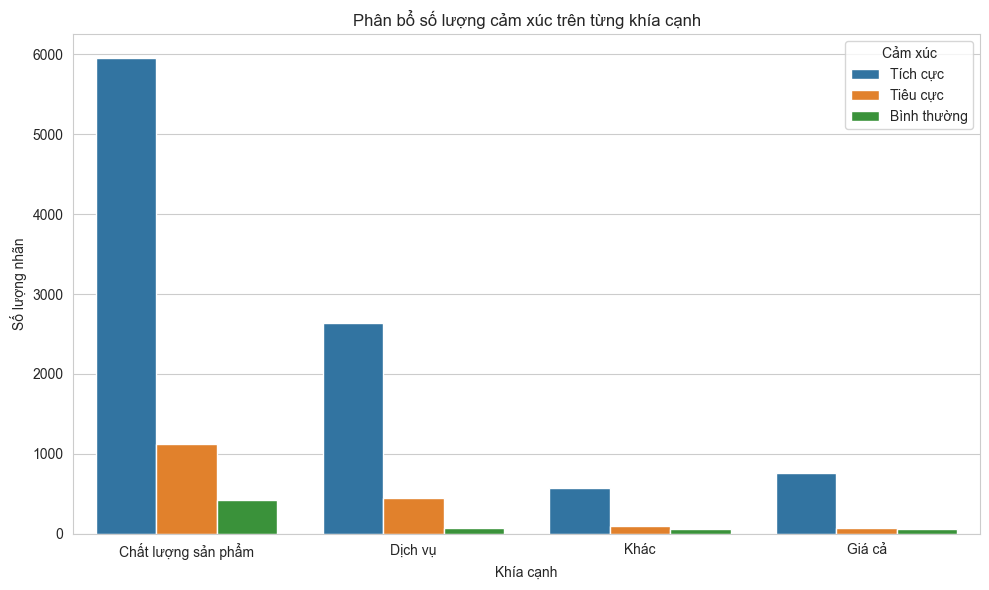

In [7]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(data=as_df, x='Aspect', y='Count', hue='Sentiment')
plt.title('Phân bổ số lượng cảm xúc trên từng khía cạnh')
plt.xlabel('Khía cạnh')
plt.ylabel('Số lượng nhãn')
plt.legend(title='Cảm xúc')
plt.tight_layout()
plt.show()


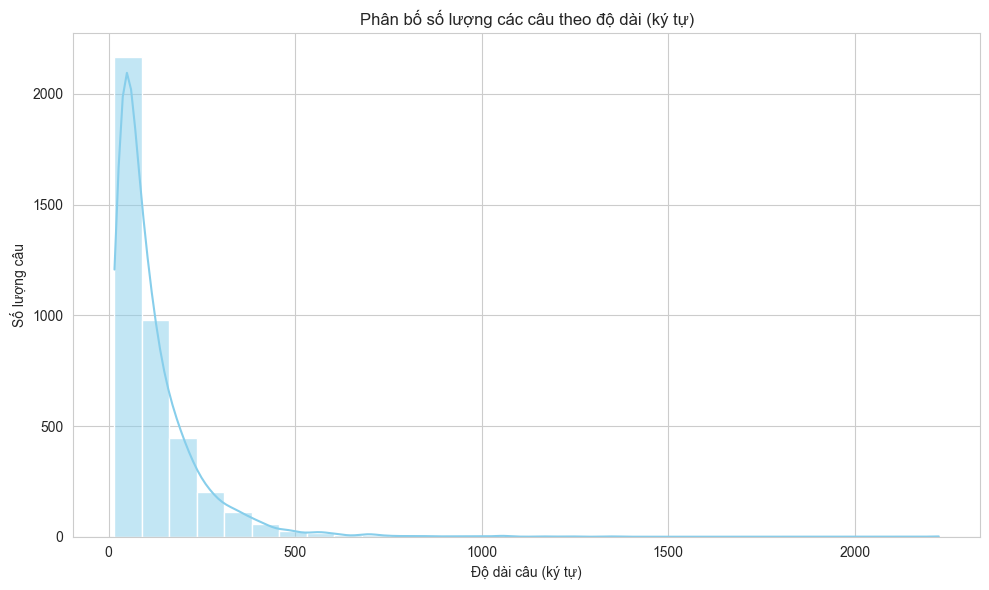

In [8]:
# Giả sử bạn đã có biến text_lengths như sau:
# text_lengths = [len(text) for text in texts]

plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=30, kde=True, color='skyblue')
plt.title('Phân bố số lượng các câu theo độ dài (ký tự)')
plt.xlabel('Độ dài câu (ký tự)')
plt.ylabel('Số lượng câu')
plt.tight_layout()
plt.show()


In [9]:
# Most common entities
print("Top 10 entities xuất hiện nhiều nhất:")
top_entities = sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)[:10]
for entity, count in top_entities:
    print(f"  {entity}: {count}")

Top 10 entities xuất hiện nhiều nhất:
  giao hàng nhanh: 263
  Giao hàng nhanh: 179
  đóng gói cẩn thận: 117
  giao nhanh: 80
  Giao nhanh: 47
  giá rẻ: 39
  chất lượng tốt: 37
  Đóng gói cẩn thận: 36
  giá tốt: 35
  sản phẩm tốt: 32


#### VISUALIZATION - PHÂN PHỐI NHÃN

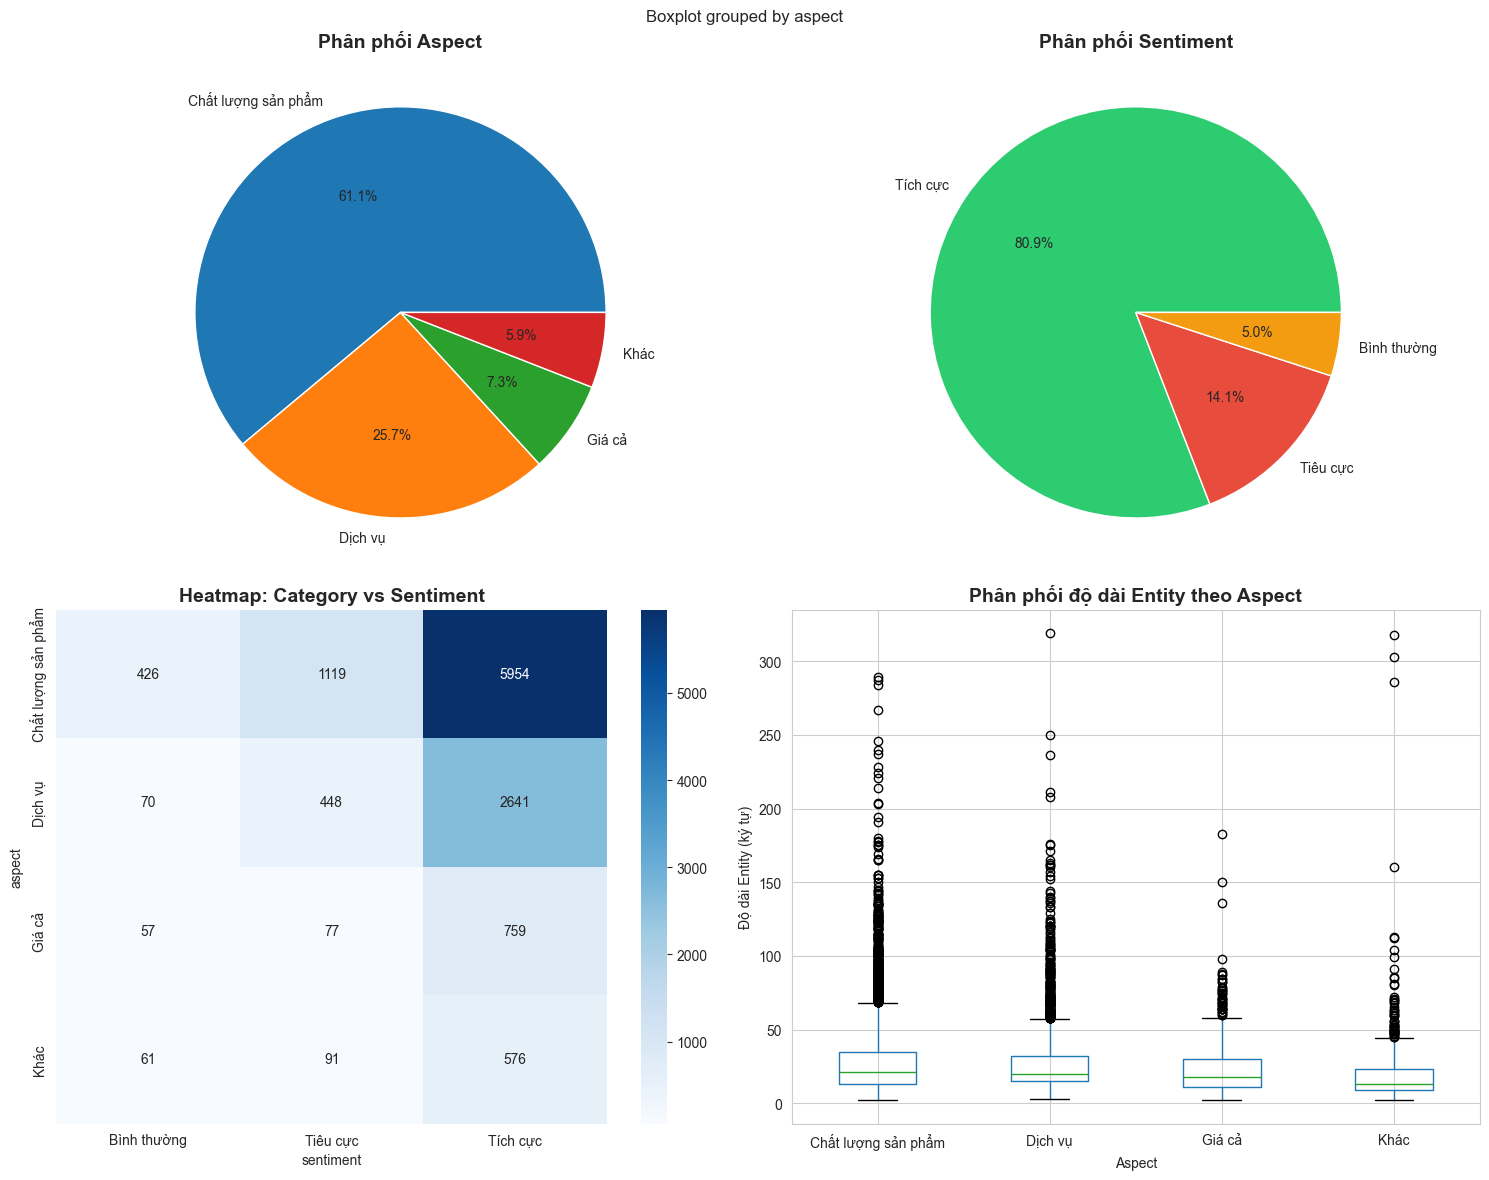

In [17]:
def plot_label_distribution(df):
    """Vẽ biểu đồ phân phối nhãn"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Phân phối Aspect
    category_counts = df['aspect'].value_counts()
    axes[0,0].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
    axes[0,0].set_title('Phân phối Aspect', fontsize=14, fontweight='bold')
    
    # 2. Phân phối Sentiment
    sentiment_counts = df['sentiment'].value_counts()
    colors = ['#2ecc71', '#e74c3c', '#f39c12']  # Green, Red, Orange
    axes[0,1].pie(sentiment_counts.values, labels=sentiment_counts.index, 
                  autopct='%1.1f%%', colors=colors[:len(sentiment_counts)])
    axes[0,1].set_title('Phân phối Sentiment', fontsize=14, fontweight='bold')
    
    # 3. Aspect vs Sentiment heatmap
    crosstab = pd.crosstab(df['aspect'], df['sentiment'])
    sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
    axes[1,0].set_title('Heatmap: Category vs Sentiment', fontsize=14, fontweight='bold')
    
    # 4. Độ dài entity theo category
    df.boxplot(column='entity_length', by='aspect', ax=axes[1,1])
    axes[1,1].set_title('Phân phối độ dài Entity theo Aspect', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Aspect')
    axes[1,1].set_ylabel('Độ dài Entity (ký tự)')
    
    plt.tight_layout()
    plt.show()

plot_label_distribution(labels_df)


In [18]:
def plot_sentiment_distribution(sentiment_counts):
    """Plot sentiment distribution"""
    plt.figure(figsize=(10, 6))
    sentiments = list(sentiment_counts.keys())
    counts = list(sentiment_counts.values())
    
    colors = ['green', 'red', 'orange'][:len(sentiments)]
    plt.bar(sentiments, counts, color=colors, alpha=0.7)
    plt.title('Phân phối Sentiment', fontsize=14, fontweight='bold')
    plt.xlabel('Sentiment')
    plt.ylabel('Số lượng')
    
    # Add value labels on bars
    for i, v in enumerate(counts):
        plt.text(i, v + max(counts)*0.01, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def plot_aspect_distribution(aspect_counts):
    """Plot aspect distribution"""
    plt.figure(figsize=(12, 6))
    aspects = list(aspect_counts.keys())
    counts = list(aspect_counts.values())
    
    plt.bar(range(len(aspects)), counts, alpha=0.7)
    plt.title('Phân phối Aspects', fontsize=14, fontweight='bold')
    plt.xlabel('Aspects')
    plt.ylabel('Số lượng')
    plt.xticks(range(len(aspects)), aspects, rotation=45, ha='right')
    
    # Add value labels on bars
    for i, v in enumerate(counts):
        plt.text(i, v + max(counts)*0.01, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def plot_aspect_sentiment_heatmap(aspect_sentiment_counts):
    """Plot aspect-sentiment heatmap"""
    # Prepare data for heatmap
    aspects = list(aspect_sentiment_counts.keys())
    all_sentiments = set()
    for sentiments in aspect_sentiment_counts.values():
        all_sentiments.update(sentiments.keys())
    all_sentiments = sorted(list(all_sentiments))
    
    heatmap_data = []
    for aspect in aspects:
        row = []
        for sentiment in all_sentiments:
            count = aspect_sentiment_counts[aspect].get(sentiment, 0)
            row.append(count)
        heatmap_data.append(row)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, 
                xticklabels=all_sentiments,
                yticklabels=aspects,
                annot=True, 
                fmt='d',
                cmap='YlOrRd')
    plt.title('Aspect-Sentiment Distribution Heatmap', fontsize=14, fontweight='bold')
    plt.xlabel('Sentiment')
    plt.ylabel('Aspect')
    plt.tight_layout()
    plt.show()

def plot_text_length_distribution(text_lengths):
    """Plot text length distribution"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(text_lengths, bins=20, alpha=0.7, color='skyblue')
    plt.title('Phân phối độ dài text (ký tự)')
    plt.xlabel('Số ký tự')
    plt.ylabel('Tần suất')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(text_lengths)
    plt.title('Box plot độ dài text')
    plt.ylabel('Số ký tự')
    
    plt.tight_layout()
    plt.show()

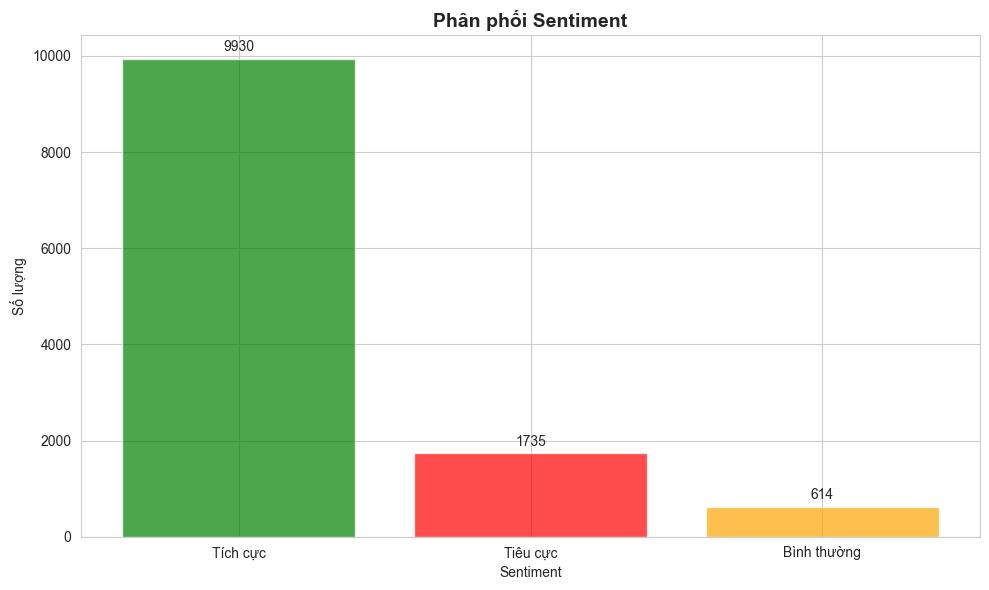

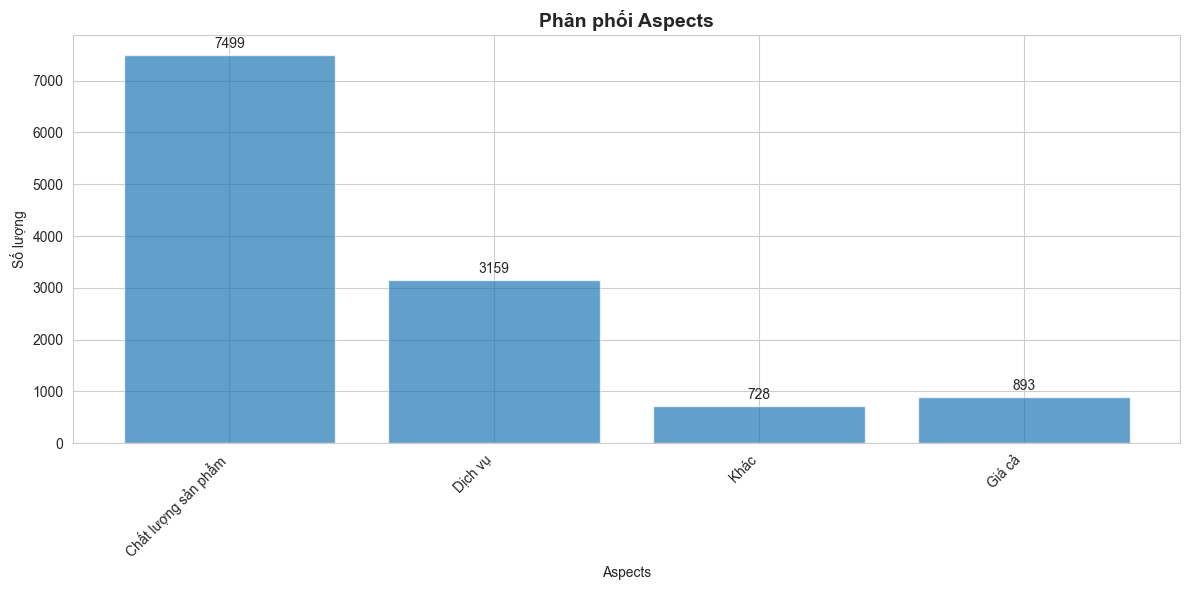

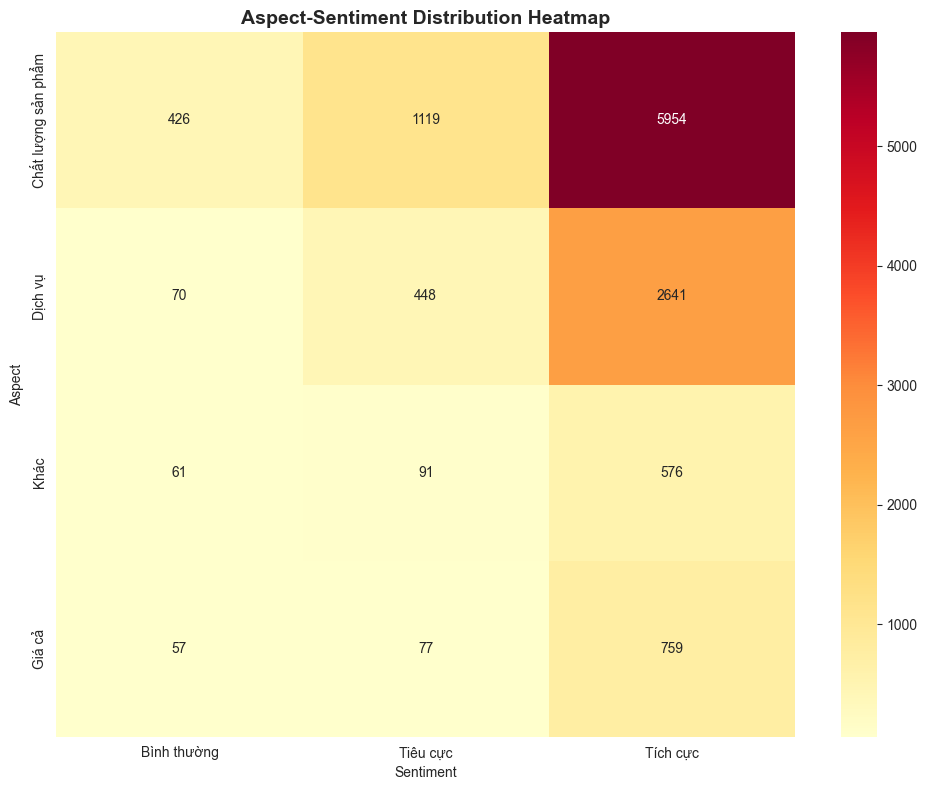

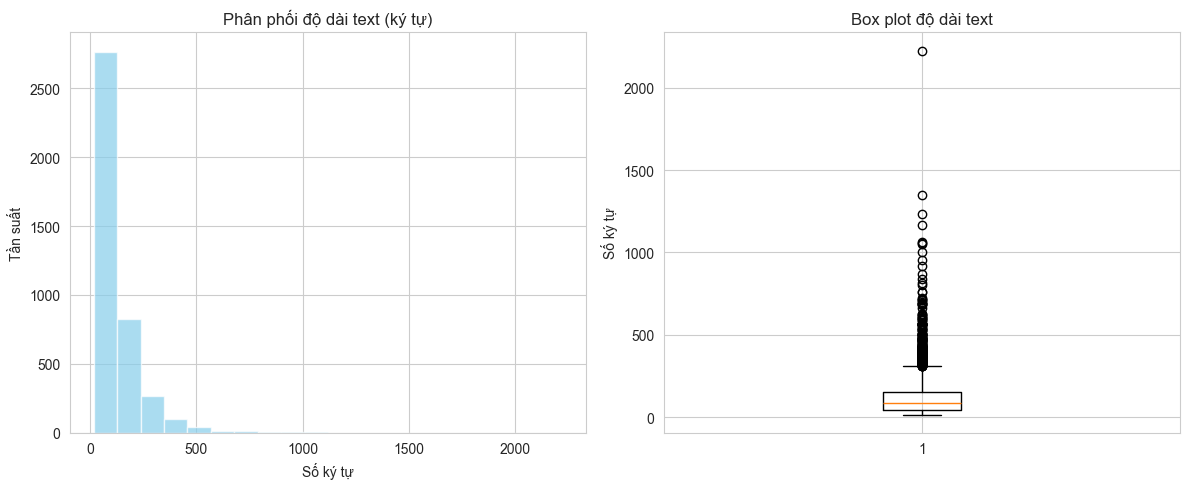

In [19]:
# Visualizations
plot_sentiment_distribution(sentiment_counts)
plot_aspect_distribution(aspect_counts)
plot_aspect_sentiment_heatmap(aspect_sentiment_counts)
plot_text_length_distribution(text_lengths)

#### PHÂN TÍCH THEO CATEGORY

In [22]:
def analyze_by_category(df):
    """Phân tích chi tiết theo từng category"""
    print("=" * 50)
    print("🔍 PHÂN TÍCH THEO CATEGORY")
    print("=" * 50)
    
    for category in df['aspect'].unique():
        cat_data = df[df['aspect'] == category]
        print(f"\n📂 {category.upper()}:")
        print(f"   • Số lượng: {len(cat_data)} entities")
        print(f"   • Sentiment tích cực: {len(cat_data[cat_data['sentiment'] == 'Tích cực'])}")
        print(f"   • Sentiment tiêu cực: {len(cat_data[cat_data['sentiment'] == 'Tiêu cực'])}")
        print(f"   • Sentiment bình thường: {len(cat_data[cat_data['sentiment'] == 'Bình thường'])}")
        
        # Top entities cho category này
        top_entities = cat_data['text_snippet'].value_counts().head(3)
        print("   • Top entities:", ", ".join(f'"{ent}"' for ent in top_entities.index))

analyze_by_category(labels_df)

🔍 PHÂN TÍCH THEO CATEGORY

📂 CHẤT LƯỢNG SẢN PHẨM:
   • Số lượng: 7499 entities
   • Sentiment tích cực: 5954
   • Sentiment tiêu cực: 1119
   • Sentiment bình thường: 426
   • Top entities: "chất lượng tốt", "sản phẩm tốt", "date xa"

📂 DỊCH VỤ:
   • Số lượng: 3159 entities
   • Sentiment tích cực: 2641
   • Sentiment tiêu cực: 448
   • Sentiment bình thường: 70
   • Top entities: "giao hàng nhanh", "Giao hàng nhanh", "đóng gói cẩn thận"

📂 KHÁC:
   • Số lượng: 728 entities
   • Sentiment tích cực: 576
   • Sentiment tiêu cực: 91
   • Sentiment bình thường: 61
   • Top entities: "rất hài lòng", "Rất hài lòng", "Hài lòng"

📂 GIÁ CẢ:
   • Số lượng: 893 entities
   • Sentiment tích cực: 759
   • Sentiment tiêu cực: 77
   • Sentiment bình thường: 57
   • Top entities: "giá rẻ", "giá tốt", "giá cả hợp lý"


#### TRAIN/VAL/TEST SPLIT SIMULATION 

In [27]:
def simulate_train_val_test_split(df, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """Mô phỏng phân chia dữ liệu thành train/val/test"""
    print("=" * 50)
    print("🎯 MÔ PHỎNG PHÂN CHIA DỮ LIỆU")
    print("=" * 50)
    
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Tổng tỷ lệ phải bằng 1"
    
    unique_texts = df['text_snippet'].unique()
    n_texts = len(unique_texts)
    
    n_train = int(n_texts * train_ratio)
    n_val = int(n_texts * val_ratio)
    n_test = n_texts - n_train - n_val
    
    print(f"📊 Phân chia dữ liệu:")
    print(f"   • Train: {n_train} reviews ({train_ratio*100:.1f}%)")
    print(f"   • Validation: {n_val} reviews ({val_ratio*100:.1f}%)")
    print(f"   • Test: {n_test} reviews ({test_ratio*100:.1f}%)")
    
    np.random.seed(42)
    shuffled_indices = np.random.permutation(n_texts)
    
    train_texts = unique_texts[shuffled_indices[:n_train]]
    val_texts = unique_texts[shuffled_indices[n_train:n_train+n_val]]
    test_texts = unique_texts[shuffled_indices[n_train+n_val:]]
    
    train_df = df[df['text_snippet'].isin(train_texts)]
    val_df = df[df['text_snippet'].isin(val_texts)]
    test_df = df[df['text_snippet'].isin(test_texts)]
    
    splits = {'Train': train_df, 'Validation': val_df, 'Test': test_df}

    print(f"\n📈 Phân phối Sentiment trong các split:")
    sentiment_dist = pd.DataFrame()
    for split_name, split_df in splits.items():
        if len(split_df) > 0:
            dist = split_df['sentiment'].value_counts(normalize=True) * 100
            sentiment_dist[split_name] = dist
    print(sentiment_dist.round(1))

    print(f"\n📈 Phân phối Aspect trong các split:")
    category_dist = pd.DataFrame()
    for split_name, split_df in splits.items():
        if len(split_df) > 0:
            dist = split_df['aspect'].value_counts(normalize=True) * 100
            category_dist[split_name] = dist
    print(category_dist.round(1))

    # 📚 Thống kê văn bản
    print("\n🧮 THỐNG KÊ DỮ LIỆU:")
    def get_text_stats(df):
        num_samples = len(df)
        tokens = df['text_snippet'].apply(lambda x: str(x).split())
        all_words = [word for doc in tokens for word in doc]
        vocab = set(all_words)
        avg_len = tokens.apply(len).mean()
        median_len = tokens.apply(len).median()
        return {
            "Số mẫu": num_samples,
            "Từ vựng": len(vocab),
            "Độ dài TB": round(avg_len, 2),
            "Độ dài trung vị": int(median_len)
        }

    all_df = pd.concat([train_df, val_df, test_df])
    stats = {
        'Tập dữ liệu': get_text_stats(all_df),
        'Train': get_text_stats(train_df),
        'Validation': get_text_stats(val_df),
        'Test': get_text_stats(test_df)
    }

    stat_df = pd.DataFrame(stats)
    print(stat_df)

    return train_df, val_df, test_df


# Thực hiện phân chia
train_df, val_df, test_df = simulate_train_val_test_split(labels_df)


🎯 MÔ PHỎNG PHÂN CHIA DỮ LIỆU
📊 Phân chia dữ liệu:
   • Train: 7648 reviews (80.0%)
   • Validation: 956 reviews (10.0%)
   • Test: 957 reviews (10.0%)

📈 Phân phối Sentiment trong các split:
             Train  Validation  Test
Tích cực      80.6        83.4  79.9
Tiêu cực      14.2        12.2  15.9
Bình thường    5.2         4.4   4.2

📈 Phân phối Aspect trong các split:
                     Train  Validation  Test
Chất lượng sản phẩm   62.1        55.6  59.6
Dịch vụ               24.6        33.9  25.3
Giá cả                 7.2         7.0   8.5
Khác                   6.2         3.5   6.6

🧮 THỐNG KÊ DỮ LIỆU:
                 Tập dữ liệu    Train  Validation     Test
Số mẫu              12279.00  9618.00     1431.00  1230.00
Từ vựng              5401.00  4810.00     1709.00  1577.00
Độ dài TB               6.35     6.42        5.92     6.27
Độ dài trung vị         5.00     5.00        4.00     5.00


### Text Mining Analysis

In [38]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import re

# Tiền xử lý text
def preprocess_text(text):
    # Loại bỏ số, ký tự đặc biệt, chỉ giữ chữ cái tiếng Việt
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.lower().strip()

# Tạo corpus cho mỗi sentiment
positive_texts = labels_df[labels_df['sentiment'] == 'Tích cực']['text_snippet'].apply(preprocess_text)
negative_texts = labels_df[labels_df['sentiment'] == 'Tiêu cực']['text_snippet'].apply(preprocess_text)
neutral_texts = labels_df[labels_df['sentiment'] == 'Bình thường']['text_snippet'].apply(preprocess_text)

# Word frequency analysis
def get_top_words(texts, n=20):
    vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 2))
    word_freq = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    frequencies = word_freq.sum(axis=0).A1
    word_freq_dict = dict(zip(feature_names, frequencies))
    return sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)[:n]

In [39]:
print("=== TOP WORDS - TÍCH CỰC ===")
positive_words = get_top_words(positive_texts)
for word, freq in positive_words:
    print(f"{word}: {freq}")


=== TOP WORDS - TÍCH CỰC ===
hàng: 1876
giao: 1477
nhanh: 1439
rất: 1192
tốt: 1084
giao hàng: 1051
sản: 754
phẩm: 744
sản phẩm: 730
hàng nhanh: 696
gói: 660
không: 645
giá: 629
đóng: 615
đóng gói: 592
chất: 569
tiki: 542
lượng: 527
đẹp: 515
chất lượng: 507


(-0.5, 799.5, 399.5, -0.5)

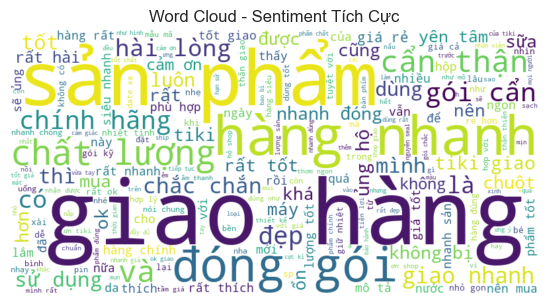

In [42]:
# Word cloud cho sentiment tích cực
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
positive_text = ' '.join(positive_texts)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Word Cloud - Sentiment Tích Cực')
plt.axis('off')

In [40]:
print("\n=== TOP WORDS - TIÊU CỰC ===")
negative_words = get_top_words(negative_texts)
for word, freq in negative_words:
    print(f"{word}: {freq}")


=== TOP WORDS - TIÊU CỰC ===
không: 614
hàng: 314
có: 279
hơi: 273
bị: 229
được: 191
giao: 188
là: 158
thì: 141
mình: 136
khi: 120
nên: 116
quá: 110
mua: 108
tiki: 101
sản: 100
hộp: 99
mà: 97
phẩm: 97
và: 96


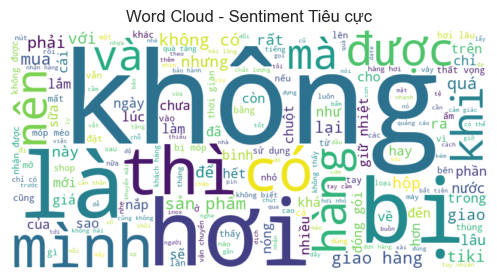

In [43]:
# Word cloud cho sentiment tiêu cực
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
negative_text = ' '.join(negative_texts)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Word Cloud - Sentiment Tiêu cực')
plt.axis('off')
plt.tight_layout()
plt.show()

In [41]:
print("\n=== TOP WORDS - BÌNH THƯỜNG ===")
neutral_words = get_top_words(neutral_texts)
for word, freq in neutral_words:
    print(f"{word}: {freq}")


=== TOP WORDS - BÌNH THƯỜNG ===
không: 179
có: 119
chưa: 105
biết: 90
được: 89
thì: 81
giá: 69
chất: 65
lượng: 61
nên: 59
dùng: 58
chất lượng: 57
mình: 55
bền: 49
mới: 49
là: 47
độ: 45
nhưng: 43
phải: 43
bình: 42


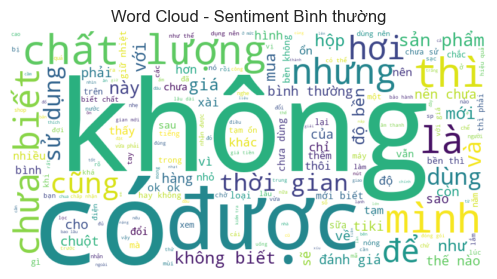

In [44]:
# Word cloud cho sentiment bình thường
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
neutral_text = ' '.join(neutral_texts)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Word Cloud - Sentiment Bình thường')
plt.axis('off')
plt.tight_layout()
plt.show()

### Correlation and Pattern Analysis

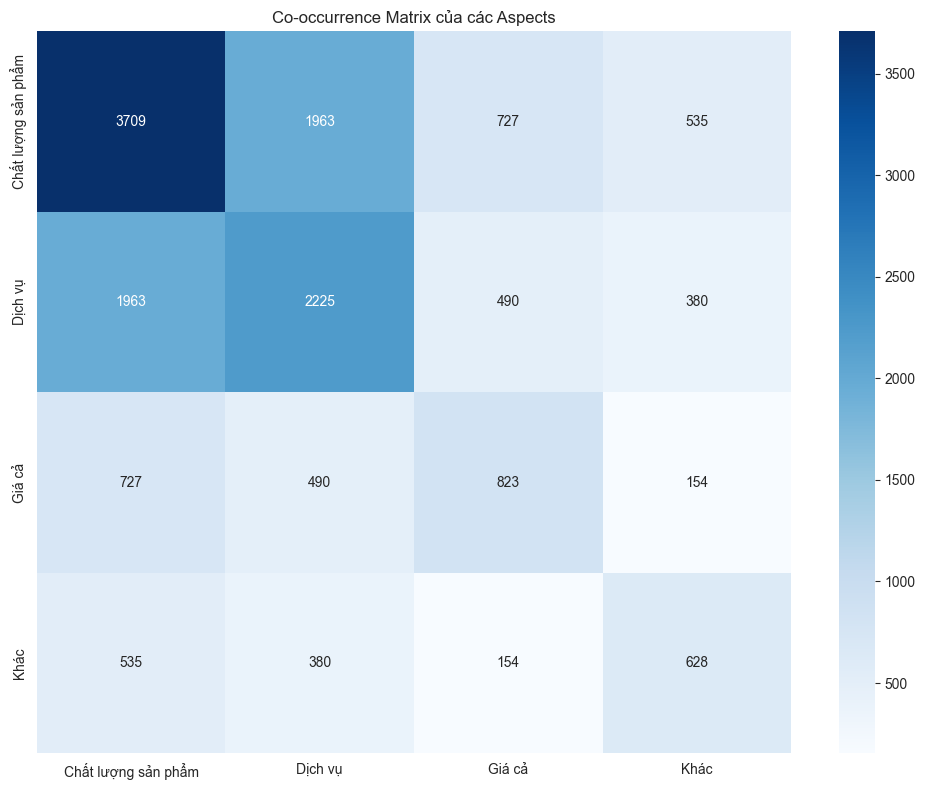

In [61]:
# Tạo matrix aspect co-occurrence
asp_counts = labels_df['aspect'].value_counts()
aspect_cooccurrence = pd.DataFrame(0, index=asp_counts.index, columns=asp_counts.index)

for review_id in labels_df['review_id'].unique():
    review_aspects = labels_df[labels_df['review_id'] == review_id]['aspect'].unique()
    for i, aspect1 in enumerate(review_aspects):
        for aspect2 in review_aspects[i:]:
            aspect_cooccurrence.loc[aspect1, aspect2] += 1
            if aspect1 != aspect2:
                aspect_cooccurrence.loc[aspect2, aspect1] += 1

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(aspect_cooccurrence, annot=True, cmap='Blues', fmt='d')
plt.title('Co-occurrence Matrix của các Aspects')
plt.tight_layout()
plt.show()

In [46]:
# Tạo DataFrame cho reviews
reviews_df = pd.DataFrame([{
    'review_id': i,
    'text': item['text'],
    'text_length': len(item['text']),
    'num_labels': len(item['labels'])
} for i, item in enumerate(data)])

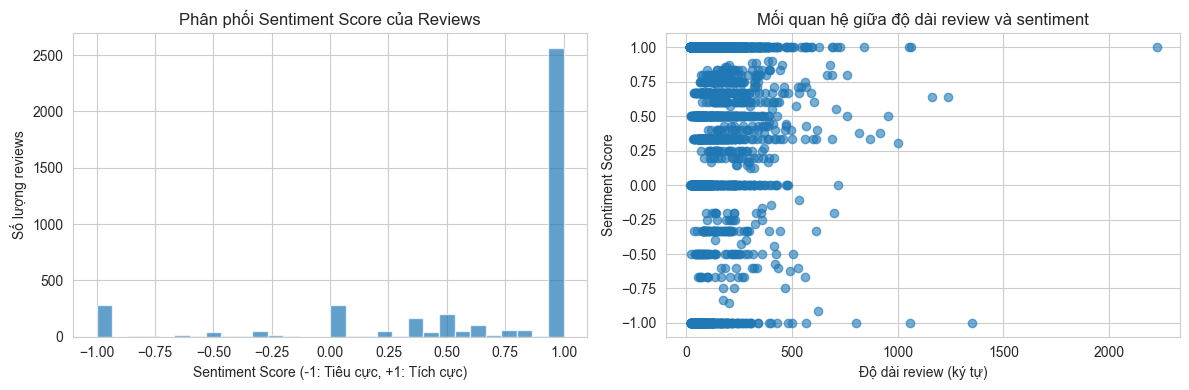

In [47]:
# Tính sentiment score cho mỗi review
review_sentiment_scores = []
for review_id in reviews_df['review_id']:
    review_labels = labels_df[labels_df['review_id'] == review_id]
    if len(review_labels) > 0:
        positive_count = (review_labels['sentiment'] == 'Tích cực').sum()
        negative_count = (review_labels['sentiment'] == 'Tiêu cực').sum()
        total_count = len(review_labels)
        sentiment_score = (positive_count - negative_count) / total_count
    else:
        sentiment_score = 0
    
    review_sentiment_scores.append({
        'review_id': review_id,
        'sentiment_score': sentiment_score,
        'positive_count': positive_count,
        'negative_count': negative_count,
        'total_aspects': total_count
    })

sentiment_df = pd.DataFrame(review_sentiment_scores)
reviews_df = reviews_df.merge(sentiment_df, on='review_id')

# Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(reviews_df['sentiment_score'], bins=30, alpha=0.7)
plt.title('Phân phối Sentiment Score của Reviews')
plt.xlabel('Sentiment Score (-1: Tiêu cực, +1: Tích cực)')
plt.ylabel('Số lượng reviews')

plt.subplot(1, 2, 2)
plt.scatter(reviews_df['text_length'], reviews_df['sentiment_score'], alpha=0.6)
plt.title('Mối quan hệ giữa độ dài review và sentiment')
plt.xlabel('Độ dài review (ký tự)')
plt.ylabel('Sentiment Score')
plt.tight_layout()
plt.show()

#### RECOMMENDATIONS

In [29]:
def provide_recommendations(df):
    """Đưa ra khuyến nghị cho việc xử lý dữ liệu"""
    print("=" * 50)
    print("💡 KHUYẾN NGHỊ VÀ GỢI Ý")
    print("=" * 50)
    
    # Kiểm tra class imbalance
    sentiment_counts = df['sentiment'].value_counts()
    max_count = sentiment_counts.max()
    min_count = sentiment_counts.min()
    imbalance_ratio = max_count / min_count
    
    print(f"⚖️ Phân tích Class Imbalance:")
    print(f"   • Tỷ lệ imbalance: {imbalance_ratio:.2f}")
    
    if imbalance_ratio > 3:
        print("   ⚠️ Dataset có vấn đề imbalance nghiêm trọng!")
        print("   💡 Khuyến nghị: Sử dụng SMOTE, class weighting, hoặc stratified sampling")
    elif imbalance_ratio > 2:
        print("   ⚠️ Dataset có imbalance vừa phải")
        print("   💡 Khuyến nghị: Sử dụng stratified split và class weighting")
    else:
        print("   ✅ Dataset tương đối cân bằng")
    
    # Phân tích độ dài text
    avg_length = df['entity_length'].mean()
    max_length = df['entity_length'].max()

    

provide_recommendations(labels_df)

💡 KHUYẾN NGHỊ VÀ GỢI Ý
⚖️ Phân tích Class Imbalance:
   • Tỷ lệ imbalance: 16.17
   ⚠️ Dataset có vấn đề imbalance nghiêm trọng!
   💡 Khuyến nghị: Sử dụng SMOTE, class weighting, hoặc stratified sampling


In [30]:
# Phân tích nhãn entity
def extract_entity_info(labels_list):
    """Trích xuất thông tin về các entity"""
    entities = []
    entity_types = []
    sentiments = []
    
    for labels in labels_list:
        for label in labels:
            start, end, entity_text, category = label
            category_parts = category.split('#')
            entity_type = category_parts[0]
            sentiment = category_parts[1] if len(category_parts) > 1 else 'Unknown'
            
            entities.append(entity_text)
            entity_types.append(entity_type)
            sentiments.append(sentiment)
    
    return entities, entity_types, sentiments

entities, entity_types, sentiments = extract_entity_info(all_labels)

print("=== THỐNG KÊ ENTITY ===")
print(f"Tổng số entity: {len(entities)}")
print(f"Số loại entity type: {len(set(entity_types))}")
print(f"Số loại sentiment: {len(set(sentiments))}")

# %%
# Phân phối Entity Types
entity_type_counts = Counter(entity_types)
print("\n=== PHÂN PHỐI ENTITY TYPES ===")
for entity_type, count in entity_type_counts.most_common():
    print(f"{entity_type}: {count} ({count/len(entity_types)*100:.1f}%)")

# %%
# Phân phối Sentiments
sentiment_counts = Counter(sentiments)
print("\n=== PHÂN PHỐI SENTIMENTS ===")
for sentiment, count in sentiment_counts.most_common():
    print(f"{sentiment}: {count} ({count/len(sentiments)*100:.1f}%)")

# %%
# Phân phối kết hợp Entity Type + Sentiment
combined_labels = [f"{et}#{s}" for et, s in zip(entity_types, sentiments)]
combined_counts = Counter(combined_labels)

print("\n=== PHÂN PHỐI KẾT HỢP (Entity Type + Sentiment) ===")
for label, count in combined_counts.most_common():
    print(f"{label}: {count} ({count/len(combined_labels)*100:.1f}%)")

=== THỐNG KÊ ENTITY ===
Tổng số entity: 12279
Số loại entity type: 4
Số loại sentiment: 3

=== PHÂN PHỐI ENTITY TYPES ===
Chất lượng sản phẩm: 7499 (61.1%)
Dịch vụ: 3159 (25.7%)
Giá cả: 893 (7.3%)
Khác: 728 (5.9%)

=== PHÂN PHỐI SENTIMENTS ===
Tích cực: 9930 (80.9%)
Tiêu cực: 1735 (14.1%)
Bình thường: 614 (5.0%)

=== PHÂN PHỐI KẾT HỢP (Entity Type + Sentiment) ===
Chất lượng sản phẩm#Tích cực: 5954 (48.5%)
Dịch vụ#Tích cực: 2641 (21.5%)
Chất lượng sản phẩm#Tiêu cực: 1119 (9.1%)
Giá cả#Tích cực: 759 (6.2%)
Khác#Tích cực: 576 (4.7%)
Dịch vụ#Tiêu cực: 448 (3.6%)
Chất lượng sản phẩm#Bình thường: 426 (3.5%)
Khác#Tiêu cực: 91 (0.7%)
Giá cả#Tiêu cực: 77 (0.6%)
Dịch vụ#Bình thường: 70 (0.6%)
Khác#Bình thường: 61 (0.5%)
Giá cả#Bình thường: 57 (0.5%)


In [31]:
def get_document_main_label(labels):
    """Lấy nhãn chính của document để stratify"""
    if not labels:
        return "Khác#Bình thường"  # default label
    
    # Đếm frequency của từng combined label trong document
    doc_labels = []
    for label in labels:
        category = label[3]  # category field
        doc_labels.append(category)
    
    # Trả về nhãn phổ biến nhất trong document
    return Counter(doc_labels).most_common(1)[0][0]

# Tạo stratification labels
stratify_labels = [get_document_main_label(labels) for labels in all_labels]
stratify_counter = Counter(stratify_labels)

In [32]:
# Phân tích độ imbalanced
def calculate_imbalance_ratio(counts):
    """Tính toán tỷ lệ imbalanced"""
    max_count = max(counts.values())
    min_count = min(counts.values())
    return max_count / min_count

entity_imbalance = calculate_imbalance_ratio(entity_type_counts)
sentiment_imbalance = calculate_imbalance_ratio(sentiment_counts)
combined_imbalance = calculate_imbalance_ratio(combined_counts)

print("=== PHÂN TÍCH ĐỘ IMBALANCED ===")
print(f"Tỷ lệ imbalanced Entity Types: {entity_imbalance:.2f}")
print(f"Tỷ lệ imbalanced Sentiments: {sentiment_imbalance:.2f}")
print(f"Tỷ lệ imbalanced Combined Labels: {combined_imbalance:.2f}")

=== PHÂN TÍCH ĐỘ IMBALANCED ===
Tỷ lệ imbalanced Entity Types: 10.30
Tỷ lệ imbalanced Sentiments: 16.17
Tỷ lệ imbalanced Combined Labels: 104.46


#### FEATURE ENGINEERING

##### Text-based Features

In [48]:
# Cài đặt: pip install underthesea
from underthesea import text_normalize
import requests

def get_vietnamese_stopwords():
    """Danh sách Vietnamese stopwords được tạo thủ công - đầy đủ nhất"""
    
    vietnamese_stopwords = [
        # Đại từ nhân xưng
        'tôi', 'bạn', 'anh', 'chị', 'em', 'ông', 'bà', 'cô', 'chú', 'cậu', 'mày', 'tao',
        'nó', 'họ', 'chúng', 'mình', 'ta', 'chúng ta', 'chúng tôi', 'các bạn',
        
        # Đại từ chỉ định
        'này', 'kia', 'đó', 'đây', 'ấy', 'nọ', 'kìa',
        
        # Động từ tobe và trợ động từ
        'là', 'thì', 'mà', 'được', 'có', 'không', 'chưa', 'đã', 'sẽ', 'đang', 'vừa',
        'bị', 'cho', 'của', 'do', 'để', 'trong', 'ngoài', 'trên', 'dưới', 'giữa',
        
        # Liên từ
        'và', 'với', 'cùng', 'hoặc', 'hay', 'nhưng', 'mà', 'song', 'tuy', 'dù', 'dẫu',
        'nếu', 'giả sử', 'vì', 'bởi vì', 'do đó', 'nên', 'cho nên', 'vậy', 'thế',
        
        # Giới từ
        'về', 'từ', 'đến', 'tại', 'ở', 'bằng', 'theo', 'dọc', 'qua', 'ra', 'vào',
        'lên', 'xuống', 'sang', 'tới', 'đi', 'lại', 'về phía', 'hướng về',
        
        # Trạng từ
        'rất', 'lắm', 'nhiều', 'ít', 'hơn', 'nữa', 'thêm', 'bớt', 'cũng', 'luôn',
        'chỉ', 'chỉ có', 'chỉ là', 'duy nhất', 'đơn thuần', 'thuần túy', 'hoàn toàn',
        'tuyệt đối', 'khá', 'khá là', 'tương đối', 'hơi', 'hơi hơi', 'thật',
        
        # Từ hỏi
        'gì', 'ai', 'đâu', 'nào', 'sao', 'thế nào', 'ra sao', 'bao giờ', 'khi nào',
        'tại sao', 'vì sao', 'tại làm sao', 'làm gì', 'bao nhiêu', 'mấy',
        
        # Từ phủ định
        'không', 'chưa', 'chẳng', 'đâu có', 'đâu phải', 'chả', 'khỏi', 'thôi',
        
        # Từ thời gian
        'hôm nay', 'ngày mai', 'hôm qua', 'tuần này', 'tuần trước', 'tuần sau',
        'tháng này', 'tháng trước', 'tháng sau', 'năm này', 'năm ngoái', 'năm sau',
        'sáng', 'trưa', 'chiều', 'tối', 'khuya', 'đêm', 'sớm', 'muộn',
        'bây giờ', 'lúc này', 'hiện tại', 'trước đây', 'sau này', 'tương lai',
        
        # Từ số lượng
        'một', 'hai', 'ba', 'bốn', 'năm', 'sáu', 'bảy', 'tám', 'chín', 'mười',
        'mười một', 'mười hai', 'hai mười', 'ba mười', 'trăm', 'nghìn', 'triệu', 'tỷ',
        'đôi', 'cặp', 'số', 'vài', 'một số', 'một vài', 'nhiều', 'ít', 'tất cả', 'mọi',
        
        # Thán từ và từ nhấn mạnh
        'ồ', 'ô', 'ơ', 'ố', 'ộ', 'ờ', 'à', 'ạ', 'ạ', 'ừ', 'ử', 'ủ', 'hả', 'hử', 'gì',
        'thế', 'ấy', 'vậy', 'như vậy', 'như thế', 'thế này', 'vậy này',
        
        # Từ logic và kết nối
        'nếu', 'thì', 'thế thì', 'vậy thì', 'như vậy thì', 'do đó', 'cho nên', 'vì thế',
        'bởi vậy', 'nên', 'mà', 'nhưng mà', 'song', 'tuy nhiên', 'tuy vậy', 'dù vậy',
        
        # Từ bổ nghĩa
        'khá', 'rất', 'lắm', 'hết sức', 'vô cùng', 'cực kỳ', 'vô cùng tận', 'hơi',
        'tương đối', 'bình thường', 'thông thường', 'thường', 'thỉnh thoảng', 'đôi khi',
        
        # Các từ khác thường gặp
        'cái', 'con', 'chiếc', 'quả', 'trái', 'hòn', 'viên', 'tờ', 'cuốn', 'quyển',
        'cây', 'cành', 'lá', 'bông', 'hoa', 'trái', 'quả',
        'ông', 'bà', 'anh', 'chị', 'em', 'cô', 'dì', 'chú', 'bác', 'thím',
        
        # Từ chỉ vị trí, hướng
        'đây', 'đó', 'kia', 'này', 'nọ', 'bên', 'cạnh', 'gần', 'xa', 'trong', 'ngoài',
        'trên', 'dưới', 'trước', 'sau', 'giữa', 'khắp', 'suốt', 'dọc', 'ngang',
        
        # Từ chỉ trạng thái
        'đang', 'đã', 'sẽ', 'vừa', 'mới', 'cũ', 'cũ rồi', 'rồi', 'xong', 'xong rồi',
        
        # Từ chỉ mức độ so sánh
        'hơn', 'kém', 'bằng', 'như', 'giống', 'giống như', 'không bằng', 'không như',
        'tốt hơn', 'kém hơn', 'bằng nhau', 'ngang nhau',
        
        # Từ chuyên dụng trong review
        'sản phẩm', 'hàng', 'đồ', 'thứ', 'loại', 'kiểu', 'dạng', 'món', 'cái',
        'shop', 'cửa hàng', 'nhà', 'công ty', 'thương hiệu', 'brand', 'mình',
        'giao hàng', 'ship', 'shipping', 'đóng gói', 'bao bì', 'hộp'
    ]
    
    return vietnamese_stopwords


In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from textstat import flesch_reading_ease
import string
from collections import Counter

def extract_text_features(df):
    """Extract comprehensive text features"""
    
    text_features = []
    
    for idx, row in df.iterrows():
        text = row['text']
        
        # Basic text statistics
        features = {
            'text_length': len(text),
            'word_count': len(text.split()),
            'sentence_count': text.count('.') + text.count('!') + text.count('?'),
            'char_count': len(text.replace(' ', '')),
            'avg_word_length': np.mean([len(word) for word in text.split()]),
            'punct_count': sum([1 for char in text if char in string.punctuation]),
            'upper_count': sum([1 for char in text if char.isupper()]),
            'digit_count': sum([1 for char in text if char.isdigit()]),
        }
        
        # Advanced text features
        vietnamese_stopwords = get_vietnamese_stopwords()
        words = text.split()
        features.update({
            'unique_word_ratio': len(set(words)) / len(words) if words else 0,
            'stopword_ratio': len([w for w in words if w.lower() in vietnamese_stopwords]) / len(words) if words else 0,
            'exclamation_count': text.count('!'),
            'question_count': text.count('?'),
            'caps_ratio': sum([1 for char in text if char.isupper()]) / len(text) if text else 0,
        })
        
        # Sentiment lexicon features
        positive_words = ['tốt', 'đẹp', 'chất lượng', 'nhanh', 'tiện', 'ổn', 'thích', 'hài lòng']
        negative_words = ['xấu', 'chậm', 'tệ', 'lỗi', 'hỏng', 'khó', 'không tốt', 'thất vọng']
        neutral_words = ['bình thường', 'tạm ổn', 'được', 'không sao', 'không rõ', 'chờ thời gian', 'chưa dùng', 'chưa sài', 'tiền nào của nấy']

        
        features.update({
            'positive_word_count': sum([1 for word in positive_words if word in text.lower()]),
            'negative_word_count': sum([1 for word in negative_words if word in text.lower()]),
            'neutral_word_count': sum([1 for word in neutral_words if word in text.lower()]),
            #'sentiment_word_ratio': (features.get('positive_word_count', 0) - features.get('negative_word_count', 0)) / len(words) if words else 0
            'sentiment_word_ratio': ( features.get('positive_word_count',0)- features.get('negative_word_count',0)) / (features.get('neutral_word_count',0) + 1)  # thêm 1 để tránh chia 0
        })
        
        text_features.append(features)
    
    return pd.DataFrame(text_features)

# Áp dụng feature extraction
text_features_df = extract_text_features(reviews_df)
reviews_extended = pd.concat([reviews_df, text_features_df], axis=1)

print("=== TEXT FEATURES EXTRACTED ===")
print(text_features_df.describe())

=== TEXT FEATURES EXTRACTED ===
       text_length   word_count  sentence_count   char_count  avg_word_length  \
count  4039.000000  4039.000000      4039.00000  4039.000000      4039.000000   
mean    119.481307    26.793266         1.68210    93.688042         3.578534   
std     120.087301    27.272098         2.88743    92.912706         0.553782   
min      16.000000     5.000000         0.00000    12.000000         2.000000   
25%      45.000000    10.000000         0.00000    36.000000         3.333333   
50%      83.000000    18.000000         1.00000    65.000000         3.516129   
75%     151.000000    34.000000         2.00000   118.000000         3.750000   
max    2225.000000   500.000000        87.00000  1726.000000        21.785714   

       punct_count  upper_count  digit_count  unique_word_ratio  \
count  4039.000000  4039.000000  4039.000000        4039.000000   
mean      3.350582     2.452835     0.933399           0.945632   
std       3.813364     4.790685     2

##### Aspect-based Features

In [50]:
def extract_aspect_features(reviews_df, labels_df):
    """Extract aspect-based features for each review"""

    aspect_features = []

    for review_id in reviews_df['review_id']:
        review_labels = labels_df[labels_df['review_id'] == review_id]

        # Basic aspect statistics
        features = {
            'num_aspects': len(review_labels),
            'num_unique_aspects': review_labels['aspect'].nunique(),
            'aspect_diversity': review_labels['aspect'].nunique() / len(review_labels) if len(review_labels) > 0 else 0,
        }

        # Aspect-specific counts
        aspect_counts = review_labels['aspect'].value_counts()
        for aspect in labels_df['aspect'].unique():
            features[f'aspect_{aspect}_count'] = aspect_counts.get(aspect, 0)

        # Sentiment distribution
        sentiment_counts = review_labels['sentiment'].value_counts()
        pos = sentiment_counts.get('Tích cực', 0)
        neg = sentiment_counts.get('Tiêu cực', 0)
        neu = sentiment_counts.get('Trung lập', 0)

        total = pos + neg + neu

        features.update({
            'positive_aspects': pos,
            'negative_aspects': neg,
            'neutral_aspects': neu,

            'sentiment_ratio': (pos - neg) / total if total > 0 else 0,
            'sentiment_balance': min(pos, neg) / max(pos, neg) if max(pos, neg) > 0 else 0,

            # Optional: tỷ lệ trung lập so với tất cả
            'neutral_ratio': neu / total if total > 0 else 0
        })

        # Position-based features
        if len(review_labels) > 0:
            text_length = len(reviews_df.loc[reviews_df['review_id'] == review_id, 'text'].iloc[0])
            features.update({
                'first_aspect_position': min(review_labels['start_pos']) / text_length,
                'last_aspect_position': max(review_labels['end_pos']) / text_length,
                'aspect_span_coverage': (max(review_labels['end_pos']) - min(review_labels['start_pos'])) / text_length
            })
        else:
            features.update({
                'first_aspect_position': 0,
                'last_aspect_position': 0,
                'aspect_span_coverage': 0
            })

        aspect_features.append(features)

    return pd.DataFrame(aspect_features)

# Extract aspect features
aspect_features_df = extract_aspect_features(reviews_df, labels_df)
reviews_extended = pd.concat([reviews_extended, aspect_features_df], axis=1)

print("=== ASPECT FEATURES EXTRACTED ===")
print(aspect_features_df.describe())


=== ASPECT FEATURES EXTRACTED ===
       num_aspects  num_unique_aspects  aspect_diversity  \
count  4039.000000         4039.000000       4039.000000   
mean      3.040109            1.828423          0.689757   
std       1.621541            0.767740          0.270471   
min       0.000000            0.000000          0.000000   
25%       2.000000            1.000000          0.500000   
50%       3.000000            2.000000          0.666667   
75%       4.000000            2.000000          1.000000   
max      20.000000            4.000000          1.000000   

       aspect_Chất lượng sản phẩm_count  aspect_Dịch vụ_count  \
count                       4039.000000           4039.000000   
mean                           1.856648              0.782124   
std                            1.352634              0.889968   
min                            0.000000              0.000000   
25%                            1.000000              0.000000   
50%                            1.00

##### N-gram và TF-IDF Features

In [51]:
def create_ngram_features(texts, max_features=1000, ngram_range=(1, 2)):
    """Create n-gram features using TF-IDF"""
    
    # Preprocess texts
    processed_texts = [preprocess_text(text) for text in texts]
    
    # TF-IDF Vectorizer
    tfidf = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        stop_words= get_vietnamese_stopwords() if 'vietnamese_stopwords' in globals() else None,
        lowercase=True,
        token_pattern=r'\b\w+\b'
    )
    
    tfidf_matrix = tfidf.fit_transform(processed_texts)
    feature_names = [f'tfidf_{name}' for name in tfidf.get_feature_names_out()]
    
    return pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names), tfidf

# Create TF-IDF features for reviews
tfidf_features, tfidf_vectorizer = create_ngram_features(reviews_df['text'])

print("=== TF-IDF FEATURES ===")
print(f"Shape: {tfidf_features.shape}")
print(f"Top features: {list(tfidf_features.columns[:10])}")

# Create TF-IDF features for aspect snippets
snippet_tfidf_features, snippet_tfidf_vectorizer = create_ngram_features(labels_df['text_snippet'], max_features=500)
print(f"Snippet TF-IDF shape: {snippet_tfidf_features.shape}")

=== TF-IDF FEATURES ===
Shape: (4039, 1000)
Top features: ['tfidf_a', 'tfidf_ai', 'tfidf_an', 'tfidf_an toàn', 'tfidf_an tâm', 'tfidf_anh', 'tfidf_ban', 'tfidf_bao', 'tfidf_bao bì', 'tfidf_biết']
Snippet TF-IDF shape: (12279, 500)


##### Temporal và Metadata Features

In [52]:
import re
from datetime import datetime

def extract_temporal_features(texts):
    """Extract temporal and metadata features from review texts"""
    
    temporal_features = []
    
    for text in texts:
        features = {}
        
        # Extract dates
        date_patterns = [
            r'\d{1,2}/\d{1,2}/\d{4}',  # DD/MM/YYYY
            r'\d{8}',  # DDMMYYYY
            r'\d{1,2}\d{1,2}\d{4}'  # DDMMYYYY
        ]
        
        dates_found = []
        for pattern in date_patterns:
            dates_found.extend(re.findall(pattern, text))
        
        features['num_dates_mentioned'] = len(dates_found)
        features['mentions_delivery_time'] = 1 if any(word in text.lower() for word in ['giao', 'nhận', 'ship']) else 0
        features['mentions_price'] = 1 if any(word in text.lower() for word in ['giá', 'tiền', 'đồng', 'nghìn']) else 0
        features['mentions_quantity'] = 1 if any(word in text.lower() for word in ['ly', 'cái', 'chiếc', 'hộp']) else 0
        
        # Extract numbers (prices, quantities)
        numbers = re.findall(r'\d+', text)
        features['num_numbers'] = len(numbers)
        features['max_number'] = max([int(n) for n in numbers]) if numbers else 0
        features['min_number'] = min([int(n) for n in numbers]) if numbers else 0
        
        # Brand mentions
        common_brands = ['locknlock', 'tiki', 'apple', 'samsung', 'xiaomi']
        features['brand_mentions'] = sum([1 for brand in common_brands if brand in text.lower()])
        
        temporal_features.append(features)
    
    return pd.DataFrame(temporal_features)

# Extract temporal features
temporal_features_df = extract_temporal_features(reviews_df['text'])
reviews_extended = pd.concat([reviews_extended, temporal_features_df], axis=1)

print("=== TEMPORAL FEATURES ===")
print(temporal_features_df.describe())

=== TEMPORAL FEATURES ===
       num_dates_mentioned  mentions_delivery_time  mentions_price  \
count          4039.000000             4039.000000     4039.000000   
mean              0.011637                0.455063        0.220847   
std               0.195576                0.498038        0.414869   
min               0.000000                0.000000        0.000000   
25%               0.000000                0.000000        0.000000   
50%               0.000000                0.000000        0.000000   
75%               0.000000                1.000000        0.000000   
max               6.000000                1.000000        1.000000   

       mentions_quantity  num_numbers    max_number    min_number  \
count        4039.000000  4039.000000  4.039000e+03  4.039000e+03   
mean            0.119336     0.580837  1.152293e+05  4.877451e+03   
std             0.324224     1.300870  4.675428e+06  2.138568e+05   
min             0.000000     0.000000  0.000000e+00  0.000000e+00  

##### Linguistic Features

In [53]:
def extract_linguistic_features(texts):
    """Extract linguistic features"""
    
    linguistic_features = []
    
    for text in texts:
        features = {}
        
        # POS-like features (simplified for Vietnamese)
        words = text.split()
        
        # Count different types of words (heuristic-based)
        adjectives = ['tốt', 'xấu', 'đẹp', 'chậm', 'nhanh', 'dễ', 'khó', 'tiện', 'lợi']
        verbs = ['mua', 'bán', 'giao', 'nhận', 'dùng', 'sử dụng', 'thích', 'ghét']
        nouns = ['hàng', 'sản phẩm', 'chất lượng', 'giá', 'tiền', 'dịch vụ']
        
        features.update({
            'adj_count': sum([1 for word in words if any(adj in word.lower() for adj in adjectives)]),
            'verb_count': sum([1 for word in words if any(verb in word.lower() for verb in verbs)]),
            'noun_count': sum([1 for word in words if any(noun in word.lower() for noun in nouns)]),
        })
        
        # Readability features
        sentences = text.split('.')
        features.update({
            'avg_sentence_length': np.mean([len(sent.split()) for sent in sentences if sent.strip()]),
            'sentence_length_std': np.std([len(sent.split()) for sent in sentences if sent.strip()]),
            'complex_sentence_ratio': sum([1 for sent in sentences if len(sent.split()) > 15]) / len(sentences) if sentences else 0
        })
        
        # Repetition features
        word_counts = Counter(words)
        features.update({
            'max_word_freq': max(word_counts.values()) if word_counts else 0,
            'repeated_words_count': sum([1 for count in word_counts.values() if count > 1]),
            'repetition_ratio': sum([count for count in word_counts.values() if count > 1]) / len(words) if words else 0
        })
        
        linguistic_features.append(features)
    
    return pd.DataFrame(linguistic_features)

# Extract linguistic features
linguistic_features_df = extract_linguistic_features(reviews_df['text'])
reviews_extended = pd.concat([reviews_extended, linguistic_features_df], axis=1)

print("=== LINGUISTIC FEATURES ===")
print(linguistic_features_df.describe())

=== LINGUISTIC FEATURES ===
         adj_count   verb_count   noun_count  avg_sentence_length  \
count  4039.000000  4039.000000  4039.000000          4039.000000   
mean      0.938351     1.122308     0.902699            13.731127   
std       1.157234     1.218723     1.098060            10.568869   
min       0.000000     0.000000     0.000000             1.666667   
25%       0.000000     0.000000     0.000000             7.000000   
50%       1.000000     1.000000     1.000000            10.666667   
75%       1.000000     2.000000     1.000000            17.000000   
max      39.000000    11.000000    12.000000           117.000000   

       sentence_length_std  complex_sentence_ratio  max_word_freq  \
count          4039.000000             4039.000000    4039.000000   
mean              2.526104                0.266554       1.801931   
std               4.534766                0.374580       1.308670   
min               0.000000                0.000000       1.000000   
25%  

##### Contextual và Sequential Features

In [54]:
def create_contextual_features(reviews_df, labels_df):
    """Create contextual features based on surrounding text"""
    
    contextual_features = []
    
    for _, row in labels_df.iterrows():
        review_text = reviews_df[reviews_df['review_id'] == row['review_id']]['text'].iloc[0]
        start_pos, end_pos = row['start_pos'], row['end_pos']
        
        # Context windows
        context_window = 50  # characters
        left_context = review_text[max(0, start_pos-context_window):start_pos]
        right_context = review_text[end_pos:min(len(review_text), end_pos+context_window)]
        
        features = {
            'label_id': f"{row['review_id']}_{start_pos}_{end_pos}",
            'aspect_length': end_pos - start_pos,
            'relative_position': start_pos / len(review_text),
            'distance_from_start': start_pos,
            'distance_from_end': len(review_text) - end_pos,
        }
        
        # Context features
        features.update({
            'left_context_length': len(left_context),
            'right_context_length': len(right_context),
            'left_context_words': len(left_context.split()),
            'right_context_words': len(right_context.split()),
        })
        
        # Surrounding sentiment indicators
        positive_words = ['tốt', 'đẹp', 'chất lượng', 'nhanh', 'tiện']
        negative_words = ['xấu', 'chậm', 'tệ', 'lỗi', 'hỏng']
        neutral_words = ['không sao', 'không rõ', 'bình thường', 'OK', 'ok']
        
        context_text = left_context + ' ' + right_context
        features.update({
            'context_positive_words': sum([1 for word in positive_words if word in context_text.lower()]),
            'context_negative_words': sum([1 for word in negative_words if word in context_text.lower()]),
            'context_neutral_words': sum([1 for word in neutral_words if word in context_text.lower()]),
            'context_sentiment_score': sum([1 for word in positive_words if word in context_text.lower()]) - sum([1 for word in negative_words if word in context_text.lower()])
        })
        
        contextual_features.append(features)
    
    return pd.DataFrame(contextual_features)

# Create contextual features
contextual_features_df = create_contextual_features(reviews_df, labels_df)

print("=== CONTEXTUAL FEATURES ===")
print(contextual_features_df.describe())

=== CONTEXTUAL FEATURES ===
       aspect_length  relative_position  distance_from_start  \
count   12279.000000       12279.000000         12279.000000   
mean       22.085593           0.299011            51.927681   
std        17.677223           0.242251            74.426098   
min         1.000000           0.000000             0.000000   
25%        12.000000           0.000000             0.000000   
50%        17.000000           0.289855            29.000000   
75%        27.000000           0.500000            67.000000   
max       302.000000           1.050980          1123.000000   

       distance_from_end  left_context_length  right_context_length  \
count       12279.000000         12279.000000          12279.000000   
mean           90.071749            27.454516             36.608763   
std           125.025040            20.570536             17.049329   
min           -37.000000             0.000000              0.000000   
25%            22.000000             0.0

##### Feature Selection and Correlation Analysis

=== HIGH CORRELATION PAIRS ===
text_length - text_length: 1.000
text_length - word_count: 0.997
text_length - char_count: 1.000
text_length - repeated_words_count: 0.928
num_labels - positive_count: 0.810
num_labels - total_aspects: 1.000
num_labels - num_aspects: 1.000
num_labels - positive_aspects: 0.811
sentiment_score - sentiment_ratio: 0.983
positive_count - total_aspects: 0.810
positive_count - num_aspects: 0.810
positive_count - positive_aspects: 1.000
negative_count - negative_aspects: 1.000
total_aspects - num_aspects: 1.000
total_aspects - positive_aspects: 0.810
text_length - word_count: 0.997
text_length - char_count: 1.000
text_length - repeated_words_count: 0.928
word_count - char_count: 0.995
word_count - repeated_words_count: 0.933
sentence_count - punct_count: 0.863
char_count - repeated_words_count: 0.926
digit_count - num_numbers: 0.888
unique_word_ratio - max_word_freq: -0.837
unique_word_ratio - repetition_ratio: -0.981
num_aspects - positive_aspects: 0.811
last_as

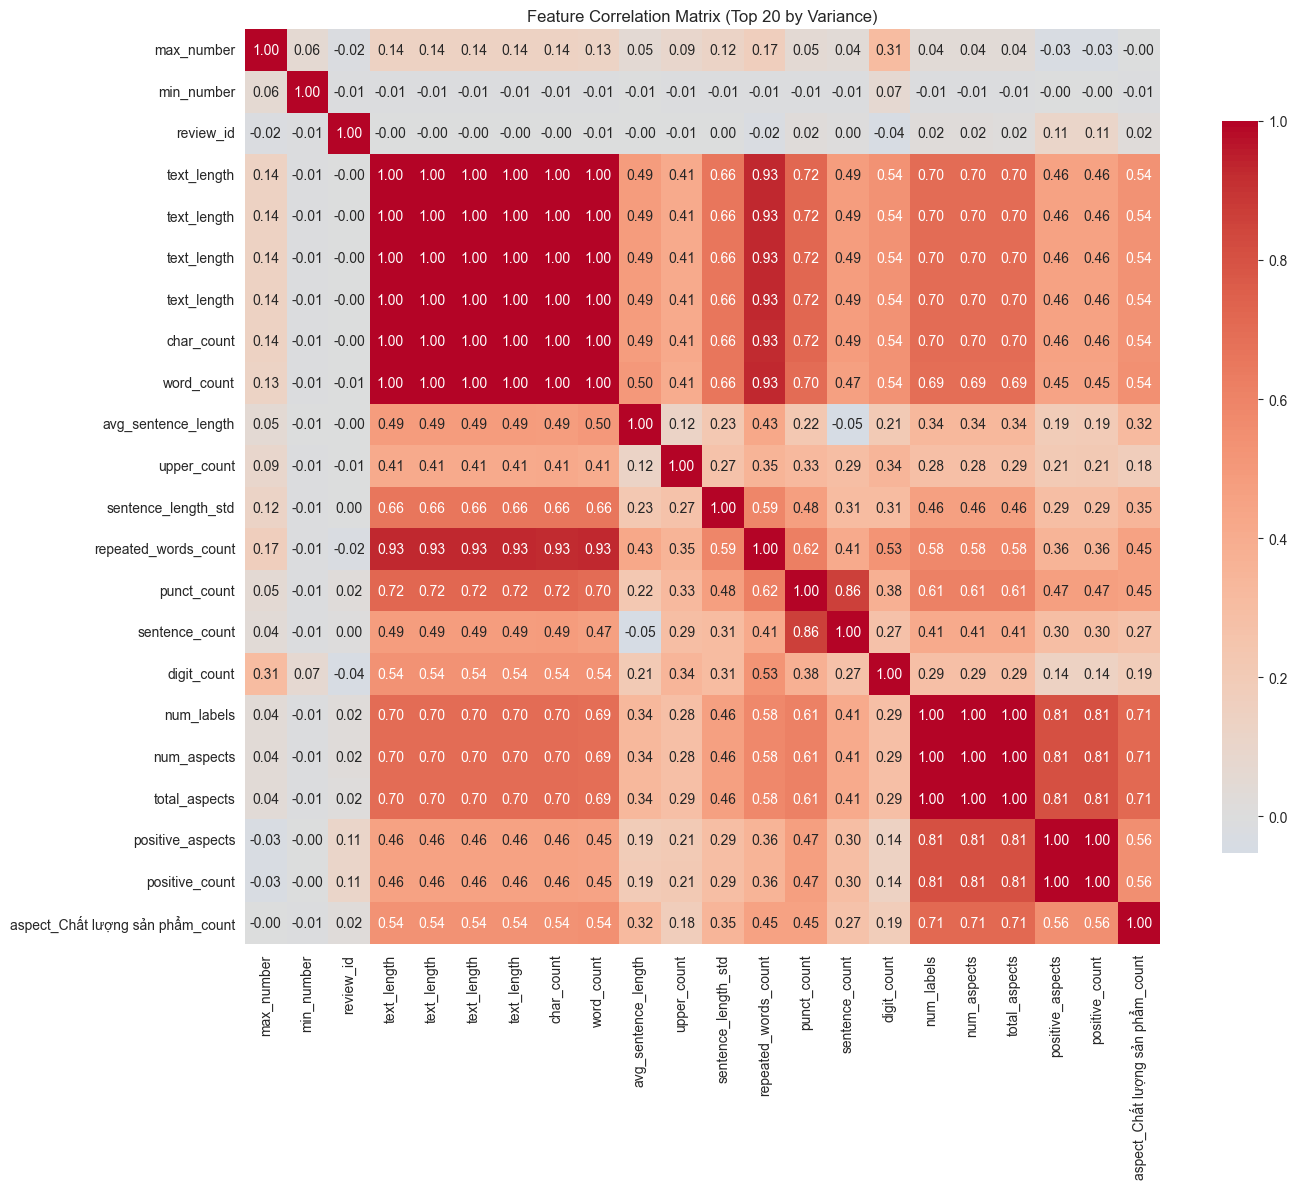

In [55]:
def analyze_feature_importance(features_df, target_col=None):
    """Analyze feature importance and correlations"""
    
    # Remove non-numeric columns
    numeric_features = features_df.select_dtypes(include=[np.number])
    
    # Correlation matrix
    corr_matrix = numeric_features.corr()
    
    # Find highly correlated features
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.8:
                high_corr_pairs.append((
                    corr_matrix.columns[i], 
                    corr_matrix.columns[j], 
                    corr_matrix.iloc[i, j]
                ))
    
    print("=== HIGH CORRELATION PAIRS ===")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"{feat1} - {feat2}: {corr:.3f}")
    
    # Feature variance
    feature_variance = numeric_features.var().sort_values(ascending=False)
    low_variance_features = feature_variance[feature_variance < 0.01].index.tolist()
    
    print(f"\n=== LOW VARIANCE FEATURES ===")
    print(f"Features with variance < 0.01: {len(low_variance_features)}")
    print(low_variance_features[:10] if len(low_variance_features) > 10 else low_variance_features)
    
    # Feature statistics
    print(f"\n=== FEATURE STATISTICS ===")
    print(f"Total features: {len(numeric_features.columns)}")
    print(f"Features with missing values: {numeric_features.isnull().sum().sum()}")
    print(f"Features with zero variance: {(numeric_features.var() == 0).sum()}")
    
    return corr_matrix, high_corr_pairs, low_variance_features

# Analyze all features
all_features = reviews_extended.select_dtypes(include=[np.number])
corr_matrix, high_corr_pairs, low_variance_features = analyze_feature_importance(all_features)

# Visualization
plt.figure(figsize=(15, 12))
# Select top 20 features by variance for visualization
top_features = all_features.var().nlargest(20).index
sns.heatmap(all_features[top_features].corr(), annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix (Top 20 by Variance)')
plt.tight_layout()
plt.show()

##### Feature Engineering Pipeline

In [56]:
class FeatureEngineeringPipeline:
    def __init__(self):
        self.tfidf_vectorizer = None
        self.feature_columns = None
        self.scaler = None
    
    def fit_transform(self, reviews_df, labels_df):
        """Complete feature engineering pipeline"""
        
        print("Starting Feature Engineering Pipeline...")
        
        # 1. Text features
        print("1. Extracting text features...")
        text_features = extract_text_features(reviews_df)
        
        # 2. Aspect features
        print("2. Extracting aspect features...")
        aspect_features = extract_aspect_features(reviews_df, labels_df)
        
        # 3. Temporal features
        print("3. Extracting temporal features...")
        temporal_features = extract_temporal_features(reviews_df['text'])
        
        # 4. Linguistic features
        print("4. Extracting linguistic features...")
        linguistic_features = extract_linguistic_features(reviews_df['text'])
        
        # 5. TF-IDF features
        print("5. Creating TF-IDF features...")
        tfidf_features, self.tfidf_vectorizer = create_ngram_features(
            reviews_df['text'], max_features=500
        )
        
        # Combine all features
        all_features = pd.concat([
            reviews_df[['review_id']],
            text_features,
            aspect_features,
            temporal_features,
            linguistic_features,
            tfidf_features
        ], axis=1)
        
        # Handle missing values
        all_features = all_features.fillna(0)
        
        # Feature selection
        print("6. Feature selection...")
        numeric_features = all_features.select_dtypes(include=[np.number])
        
        # Remove low variance features
        from sklearn.feature_selection import VarianceThreshold
        variance_selector = VarianceThreshold(threshold=0.01)
        selected_features = variance_selector.fit_transform(numeric_features)
        
        self.feature_columns = numeric_features.columns[variance_selector.get_support()].tolist()
        final_features = pd.DataFrame(selected_features, columns=self.feature_columns)
        final_features['review_id'] = all_features['review_id'].values
        
        print(f"Final feature shape: {final_features.shape}")
        print(f"Features retained: {len(self.feature_columns)}")
        
        return final_features
    
    def transform(self, reviews_df, labels_df):
        """Transform new data using fitted pipeline"""
        # Apply same transformations as in fit_transform
        # (Implementation would follow same steps but use fitted transformers)
        pass

# Apply pipeline
pipeline = FeatureEngineeringPipeline()
final_features = pipeline.fit_transform(reviews_df, labels_df)

print("=== FEATURE ENGINEERING COMPLETE ===")
print(f"Final dataset shape: {final_features.shape}")
print("Sample features:")
print(final_features.head())

Starting Feature Engineering Pipeline...
1. Extracting text features...
2. Extracting aspect features...
3. Extracting temporal features...
4. Extracting linguistic features...
5. Creating TF-IDF features...
6. Feature selection...
Final feature shape: (4039, 46)
Features retained: 46
=== FEATURE ENGINEERING COMPLETE ===
Final dataset shape: (4039, 46)
Sample features:
   review_id  text_length  word_count  sentence_count  char_count  \
0          0        561.0       130.0             9.0       432.0   
1          1        336.0        75.0             6.0       262.0   
2          2        249.0        60.0             0.0       190.0   
3          3        502.0       115.0             2.0       388.0   
4          4        282.0        60.0             3.0       223.0   

   avg_word_length  punct_count  upper_count  digit_count  stopword_ratio  \
0         3.323077         14.0         15.0         37.0        0.284615   
1         3.493333         10.0          8.0          3.0  

##### Feature Validation and Export

In [57]:
def validate_features(features_df):
    """Validate engineered features"""
    
    validation_report = {
        'total_features': len(features_df.columns),
        'total_samples': len(features_df),
        'missing_values': features_df.isnull().sum().sum(),
        'infinite_values': np.isinf(features_df.select_dtypes(include=[np.number])).sum().sum(),
        'constant_features': (features_df.nunique() == 1).sum(),
        'feature_ranges': {}
    }
    
    # Check feature ranges
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        validation_report['feature_ranges'][col] = {
            'min': features_df[col].min(),
            'max': features_df[col].max(),
            'mean': features_df[col].mean(),
            'std': features_df[col].std()
        }
    
    print("=== FEATURE VALIDATION REPORT ===")
    print(f"Total features: {validation_report['total_features']}")
    print(f"Total samples: {validation_report['total_samples']}")
    print(f"Missing values: {validation_report['missing_values']}")
    print(f"Infinite values: {validation_report['infinite_values']}")
    print(f"Constant features: {validation_report['constant_features']}")
    
    return validation_report

# Validate features
validation_report = validate_features(final_features)

# Export features for model training
final_features.to_csv('C:/Users/DELL/Tiki_ABSA/notebooks/engineered_features.csv', index=False)
print("\nFeatures exported to 'engineered_features.csv'")

# Export feature metadata
feature_metadata = {
    'feature_columns': pipeline.feature_columns,
    'total_features': len(final_features.columns),
    'feature_types': {
        'text_features': [col for col in final_features.columns if any(x in col for x in ['length', 'count', 'ratio'])],
        'tfidf_features': [col for col in final_features.columns if 'tfidf_' in col],
        'aspect_features': [col for col in final_features.columns if 'aspect_' in col],
        'temporal_features': [col for col in final_features.columns if any(x in col for x in ['date', 'time', 'delivery'])],
        'linguistic_features': [col for col in final_features.columns if any(x in col for x in ['adj_', 'verb_', 'noun_'])]
    },
    'validation_report': validation_report
}

with open('C:/Users/DELL/Tiki_ABSA/notebooks/feature_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(feature_metadata, f, ensure_ascii=False, indent=2, default=str)

print("Feature metadata exported to 'feature_metadata.json'")

=== FEATURE VALIDATION REPORT ===
Total features: 46
Total samples: 4039
Missing values: 0
Infinite values: 0
Constant features: 0

Features exported to 'engineered_features.csv'
Feature metadata exported to 'feature_metadata.json'


### Summary and Insights

In [62]:
print("=== BÁO CÁO TỔNG KẾT EDA ===")
print(f"1. Tổng quan dataset:")
print(f"   - Số reviews: {len(reviews_df)}")
print(f"   - Số labels: {len(labels_df)}")
print(f"   - Số aspects: {labels_df['aspect'].nunique()}")
print(f"   - Độ dài trung bình review: {reviews_df['text_length'].mean():.0f} ký tự")

print(f"\n2. Phân bố Aspects:")
for aspect, count in asp_counts.head().items():
    print(f"   - {aspect}: {count} ({count/len(labels_df)*100:.1f}%)")

print(f"\n3. Phân bố Sentiment:")
for sentiment, count in sentiment_counts.items():
    print(f"   - {sentiment}: {count} ({count/len(labels_df)*100:.1f}%)")

print(f"\n4. Insights chính:")
print(f"   - Aspect phổ biến nhất: {asp_counts.index[0]}")
print(f"   - Tỷ lệ sentiment tích cực: {sentiment_counts.get('Tích cực', 0)/len(labels_df)*100:.1f}%")
print(f"   - Review có sentiment score trung bình: {reviews_df['sentiment_score'].mean():.2f}")

# Aspect có sentiment tích cực cao nhất
aspect_positivity = aspect_sentiment_pct['Tích cực'].sort_values(ascending=False)
print(f"   - Aspect tích cực nhất: {aspect_positivity.index[0]} ({aspect_positivity.iloc[0]:.1f}%)")
print(f"   - Aspect tiêu cực nhất: {aspect_positivity.index[-1]} ({aspect_positivity.iloc[-1]:.1f}%)")

=== BÁO CÁO TỔNG KẾT EDA ===
1. Tổng quan dataset:
   - Số reviews: 4039
   - Số labels: 12279
   - Số aspects: 4
   - Độ dài trung bình review: 119 ký tự

2. Phân bố Aspects:
   - Chất lượng sản phẩm: 7499 (61.1%)
   - Dịch vụ: 3159 (25.7%)
   - Giá cả: 893 (7.3%)
   - Khác: 728 (5.9%)

3. Phân bố Sentiment:
   - Tích cực: 9930 (80.9%)
   - Tiêu cực: 1735 (14.1%)
   - Bình thường: 614 (5.0%)

4. Insights chính:
   - Aspect phổ biến nhất: Chất lượng sản phẩm
   - Tỷ lệ sentiment tích cực: 80.9%
   - Review có sentiment score trung bình: 0.65
   - Aspect tích cực nhất: Giá cả (85.0%)
   - Aspect tiêu cực nhất: Khác (79.1%)
